# XGBoost Forecasting Pipeline

Use Case: Forecast demand for weather/event-sensitive products (e.g., ORS during heatwaves, sunscreen in summer).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import xgboost as xgb
import json

In [ ]:
df = pd.read_csv('C:/Users/Admin/NIYOJAN/Data/Synthetic/Training/xgb_data.csv')

In [5]:
df.head()

,date,product,temperature,holiday,outbreak,sales
0,2022-01-01,ORS_Solution,21.165562,1,0,81
1,2022-01-01,Paracetamol_500mg,21.165562,1,0,31
2,2022-01-01,Antibiotic_A,21.165562,1,0,27
3,2022-01-01,Sunscreen,21.165562,1,0,21
4,2022-01-01,Travel_Antidiarrheal,21.165562,1,0,21


Preprocess Data

In [6]:
le = LabelEncoder()
df["product_encoded"] = le.fit_transform(df["product"])

In [7]:
# Scale temperature
scaler = StandardScaler()
df["temp_scaled"] = scaler.fit_transform(df[["temperature"]])

In [8]:
# Features & Target
X = df[["product_encoded","temp_scaled","holiday","outbreak"]]
y = df["sales"]

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Train XGBoost Regressor

In [10]:
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [11]:
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Evaluate Model

In [13]:
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

RMSE: 6.21895886554477
R2 Score: 0.885750412940979


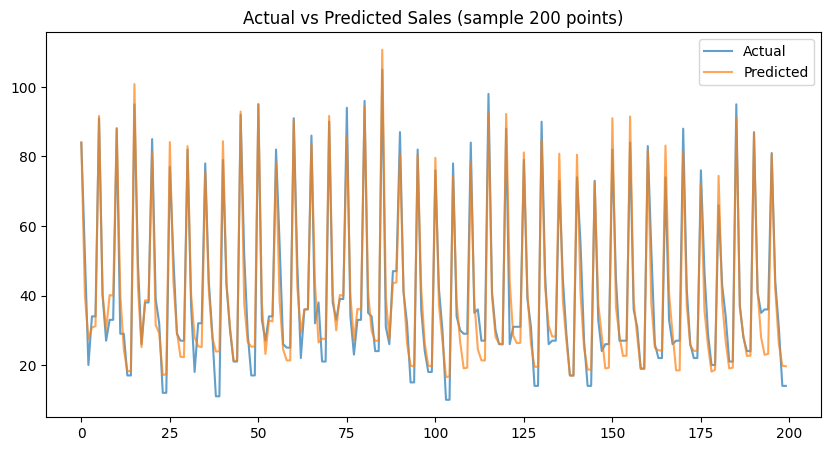

In [14]:
# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:200], label="Actual", alpha=0.7)
plt.plot(y_pred[:200], label="Predicted", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Sales (sample 200 points)")
plt.show()

Feature Importance

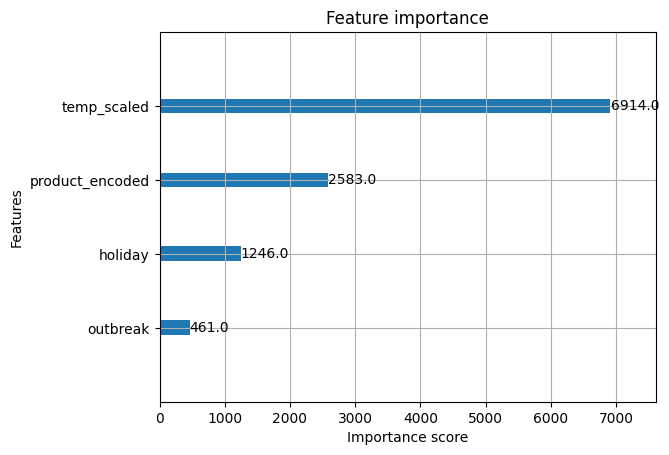

In [15]:
xgb.plot_importance(model)
plt.show()

Forecast Next 30 Days

In [18]:
from datetime import timedelta

df["date"] = pd.to_datetime(df["date"])

In [19]:
products = [
    "ORS_Solution",        # temp-sensitive (heatwaves)
    "Paracetamol_500mg",   # flu season + outbreak flags
    "Antibiotic_A",        # doctor-driven + irregular demand
    "Sunscreen",           # summer + weather
    "Travel_Antidiarrheal" # travel/holiday sensitive
]

In [20]:
future_dates = pd.date_range(
    start=df["date"].max() + timedelta(days=1),
    periods=30,
    freq="D"
)

In [21]:
forecast_data = []
for date in future_dates:
    # Features for forecast
    temp = 20 + 10*np.sin(2*np.pi*date.timetuple().tm_yday/365) + np.random.normal(0,2)
    holiday = 1 if date.weekday() in [5,6] else 0
    outbreak = 1 if (date.month in [1,2,12] and np.random.rand() < 0.05) else 0

    for product in products:
        product_encoded = le.transform([product])[0]
        temp_scaled = scaler.transform([[temp]])[0][0]

        X_future = [[product_encoded, temp_scaled, holiday, outbreak]]
        pred_sales = model.predict(X_future)[0]

        forecast_data.append([
            date,
            product,
            "XGBoost",
            int(pred_sales),
            np.nan  # keep actual as NaN
        ])

c:\Users\Admin\miniconda3\envs\dl_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Admin\miniconda3\envs\dl_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Admin\miniconda3\envs\dl_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Admin\miniconda3\envs\dl_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Admin\miniconda3\envs\dl_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with f

In [22]:
forecast_df = pd.DataFrame(
    forecast_data,
    columns=["Date", "Product", "Model", "Forecast", "Actual"]
)

In [23]:
forecast_df.sample(10)

,Date,Product,Model,Forecast,Actual
77,2024-12-16,Antibiotic_A,XGBoost,25,NaN
44,2024-12-09,Travel_Antidiarrheal,XGBoost,21,NaN
135,2024-12-28,ORS_Solution,XGBoost,76,NaN
51,2024-12-11,Paracetamol_500mg,XGBoost,37,NaN
60,2024-12-13,ORS_Solution,XGBoost,64,NaN
50,2024-12-11,ORS_Solution,XGBoost,66,NaN
123,2024-12-25,Sunscreen,XGBoost,22,NaN
124,2024-12-25,Travel_Antidiarrheal,XGBoost,22,NaN
72,2024-12-15,Antibiotic_A,XGBoost,29,NaN
73,2024-12-15,Sunscreen,XGBoost,23,NaN


In [ ]:
import pickle

# Save model
with open("C:/Users/Admin/NIYOJAN/Models/XGBoost/xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
test_df=pd.read_csv("C:/Users/Admin/NIYOJAN/Data/Synthetic/Test/xgb_data.csv")

In [26]:
test_df.head()

,date,product,temperature,holiday,outbreak,sales
0,2024-12-01,ORS_Solution,15.747612,1,0,80
1,2024-12-01,Paracetamol_500mg,15.747612,1,0,46
2,2024-12-01,Antibiotic_A,15.747612,1,0,32
3,2024-12-01,Sunscreen,15.747612,1,0,28
4,2024-12-01,Travel_Antidiarrheal,15.747612,1,0,28


In [27]:
# Convert forecast Date to datetime (if not already)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# Convert actuals Date to datetime
test_df['date'] = pd.to_datetime(test_df['date'])

In [28]:
print(test_df['date'].min(), test_df['date'].max())
print(forecast_df['Date'].min(), forecast_df['Date'].max())

2024-12-01 00:00:00 2024-12-30 00:00:00
2024-12-01 00:00:00 2024-12-30 00:00:00


In [29]:
forecast_df['Product'] = forecast_df['Product'].str.strip()
test_df['product'] = test_df['product'].str.strip()
forecast_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      150 non-null    datetime64[ns]
 1   Product   150 non-null    object        
 2   Model     150 non-null    object        
 3   Forecast  150 non-null    int64         
 4   Actual    0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 6.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         150 non-null    datetime64[ns]
 1   product      150 non-null    object        
 2   temperature  150 non-null    float64       
 3   holiday      150 non-null    int64         
 4   outbreak     150 non-null    int64         
 5   sales        150 non-null    int64       

In [31]:
forecast_df = forecast_df.merge(test_df[['date','product','sales']], 
                                left_on=['Date','Product'],
                                right_on=['date','product'],
                                how='left')
forecast_df['Actual'] = forecast_df['sales']

In [32]:
forecast_df.sample(10)

,Date,Product,Model,Forecast,Actual,date,product,sales
20,2024-12-05,ORS_Solution,XGBoost,65,51,2024-12-05,ORS_Solution,51
66,2024-12-14,Paracetamol_500mg,XGBoost,35,47,2024-12-14,Paracetamol_500mg,47
125,2024-12-26,ORS_Solution,XGBoost,67,78,2024-12-26,ORS_Solution,78
111,2024-12-23,Paracetamol_500mg,XGBoost,61,28,2024-12-23,Paracetamol_500mg,28
105,2024-12-22,ORS_Solution,XGBoost,75,80,2024-12-22,ORS_Solution,80
46,2024-12-10,Paracetamol_500mg,XGBoost,40,45,2024-12-10,Paracetamol_500mg,45
65,2024-12-14,ORS_Solution,XGBoost,64,60,2024-12-14,ORS_Solution,60
99,2024-12-20,Travel_Antidiarrheal,XGBoost,20,16,2024-12-20,Travel_Antidiarrheal,16
55,2024-12-12,ORS_Solution,XGBoost,64,55,2024-12-12,ORS_Solution,55
97,2024-12-20,Antibiotic_A,XGBoost,30,21,2024-12-20,Antibiotic_A,21


In [33]:
forecast_df.drop(['product','sales','date'], axis=1, inplace=True)

In [35]:
forecast_df.sample(10)

,Date,Product,Model,Forecast,Actual
7,2024-12-02,Antibiotic_A,XGBoost,28,26
64,2024-12-13,Travel_Antidiarrheal,XGBoost,19,18
3,2024-12-01,Sunscreen,XGBoost,19,28
58,2024-12-12,Sunscreen,XGBoost,18,17
55,2024-12-12,ORS_Solution,XGBoost,64,55
8,2024-12-02,Sunscreen,XGBoost,20,27
37,2024-12-08,Antibiotic_A,XGBoost,28,38
39,2024-12-08,Travel_Antidiarrheal,XGBoost,21,15
72,2024-12-15,Antibiotic_A,XGBoost,29,26
143,2024-12-29,Sunscreen,XGBoost,14,22


In [ ]:
forecast_df.to_csv("C:/Users/Admin/NIYOJAN/Forecasts/XGBoost/xgboost_forecast.csv", index=False)